In [1]:
# Import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [10]:
#  Chargement des données
train_df = pd.read_csv('airbnb_train.csv')
test_df = pd.read_csv('airbnb_test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head(2)
test_df.head(2)

Train shape: (22234, 28)
Test shape: (51877, 27)


,Unnamed: 0,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,14282777,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,11201,1.0,1.0
1,17029381,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,10019,3.0,3.0


## Analyse exploratoire 

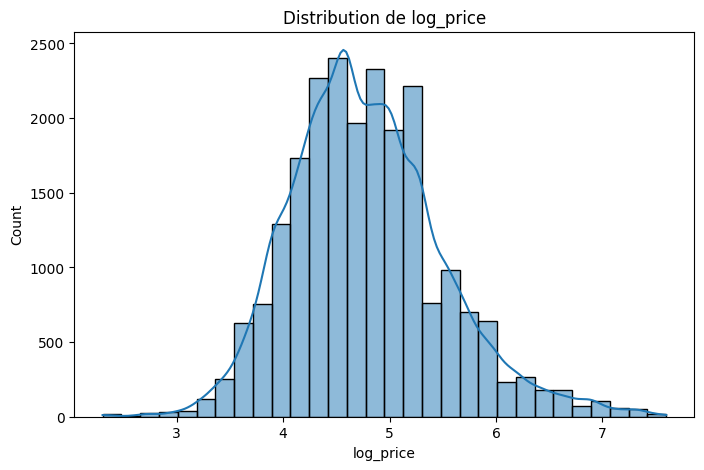

In [3]:

# Distribution du log_price
plt.figure(figsize=(8,5))
sns.histplot(train_df['log_price'], kde=True, bins=30)
plt.title('Distribution de log_price')
plt.show()

In [4]:
# Variables avec valeurs manquantes
missing = train_df.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0])

host_response_rate        0.246244
review_scores_rating      0.223891
first_review              0.212512
last_review               0.212108
neighbourhood             0.093820
zipcode                   0.013628
host_has_profile_pic      0.002519
host_identity_verified    0.002519
host_since                0.002519
bathrooms                 0.002294
beds                      0.001574
bedrooms                  0.001169
dtype: float64


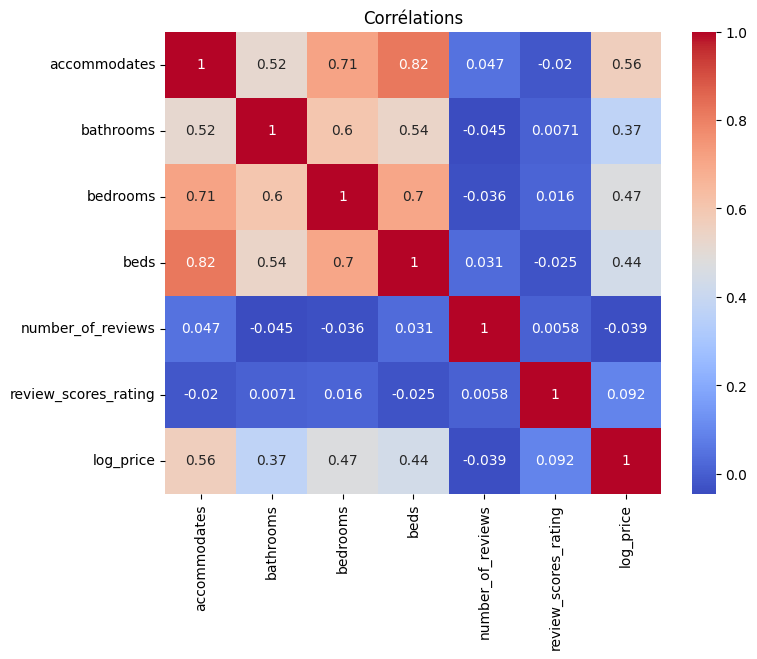

In [5]:
# Exemple : corrélation avec log_price
numeric_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating']
corr = train_df[numeric_features + ['log_price']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Corrélations')
plt.show()

###  4. Prétraitement et Feature Engineering

In [28]:
# Renommer une colonne spécifique (par exemple la première)
test_df.rename(columns={test_df.columns[0]: 'id'}, inplace=True)


,id,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,14282777,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,...,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,11201,1.0,1.0
1,17029381,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,10019,3.0,3.0


In [29]:

# Liste des colonnes utiles
features = [
    'property_type', 'room_type', 'bed_type', 'cancellation_policy',
    'city', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'number_of_reviews', 'review_scores_rating',
    'instant_bookable', 'host_has_profile_pic', 'host_identity_verified'
]

X = train_df.drop(['id', 'log_price'], axis=1)
y = train_df['log_price']
X_test = test_df.drop(['id'], axis=1)


# Colonnes numériques et catégorielles
num_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating']
cat_cols = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city', 'neighbourhood']
bool_cols = ['instant_bookable', 'host_has_profile_pic', 'host_identity_verified']


In [31]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

all_data = pd.concat([X[col], X_test[col]], axis=0).astype(str).fillna('missing')
le.fit(all_data)

X[col] = le.transform(X[col].astype(str).fillna('missing'))
X_test[col] = le.transform(X_test[col].astype(str).fillna('missing'))



### 5. Modèle de Régression Linéaire

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Colonnes numériques et catégorielles
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city', 'neighbourhood']

# Imputers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Remplace les NaN par la moyenne
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Remplace les NaN par 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Pipeline complet avec LinearRegression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entraînement
model.fit(X, y)

# Prédictions
y_pred = model.predict(X_test)


In [35]:
# Entraînement du modèle
print("Début de l'entraînement...")
model.fit(X, y)
print("Entraînement terminé.")

# Prédiction
print("Début de la prédiction...")
y_pred = model.predict(X_test)
print("Prédictions terminées.")

# Affichage des premières prédictions
print("Quelques prédictions : ", y_pred[:5])


Début de l'entraînement...
Entraînement terminé.
Début de la prédiction...
Prédictions terminées.
Quelques prédictions :  [5.44296491 6.19599487 5.30605781 6.16580466 4.67424274]


In [36]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)  # Remplace y_test par les vraies valeurs si dispo
rmse = np.sqrt(mse)
print("RMSE :", rmse)


NameError: name 'y_test' is not defined